# Multi-Agent Systems with Semantic Kernel

Welcome to this workshop on multi-agent systems using Semantic Kernel! In this notebook, we'll explore how to create, configure, and orchestrate multiple agents to collaborate in solving complex tasks.

## What You'll Learn
- How to transition from single agents to multi-agent systems
- The fundamentals of AgentGroupChat for agent collaboration
- How to design specialized agents with different roles
- Strategies for managing agent conversations and turn-taking
- Techniques for controlling conversation flow and termination

Let's start by setting up our environment.

In [ ]:
# Install required packages
!pip install semantic-kernel python-dotenv

In [20]:
import os
import asyncio
from dotenv import load_dotenv

# Import Semantic Kernel components
import semantic_kernel as sk
from semantic_kernel.agents import ChatCompletionAgent, AgentGroupChat
from semantic_kernel.connectors.ai.open_ai import (
    AzureChatCompletion,
    OpenAIChatCompletion,
)
from semantic_kernel.contents import ChatHistory, ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions import KernelArguments
from semantic_kernel.agents.strategies import (
    KernelFunctionSelectionStrategy,
    KernelFunctionTerminationStrategy,
    SequentialSelectionStrategy,
    DefaultTerminationStrategy,
)

from semantic_kernel.agents.strategies.selection.selection_strategy import (
    SelectionStrategy,
)


# Load environment variables from .env file
load_dotenv()

print("Environment set up successfully!")

Environment set up successfully!


Let's create our helper function for setting up a kernel with AI services, similar to what we used in the previous notebook:

In [2]:
def create_kernel_with_service(service_id="default"):
    """Create a kernel with either Azure OpenAI or OpenAI service based on available credentials."""
    kernel = sk.Kernel()

    # Try to use Azure OpenAI first
    if (
        os.getenv("AZURE_OPENAI_API_KEY")
        and os.getenv("AZURE_OPENAI_ENDPOINT")
        and os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
    ):
        print("Using Azure OpenAI service")
        kernel.add_service(
            AzureChatCompletion(
                service_id=service_id,
                deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
                endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
            )
        )
    # Fall back to OpenAI
    elif os.getenv("OPENAI_API_KEY"):
        print("Using OpenAI service")
        kernel.add_service(
            OpenAIChatCompletion(
                service_id=service_id,
                api_key=os.getenv("OPENAI_API_KEY"),
                model_id="gpt-4",
            )
        )
    else:
        raise ValueError(
            "No AI service credentials found. Please set up your .env file."
        )

    return kernel


# Create our kernel
kernel = create_kernel_with_service(service_id="multi-agent")
print("Kernel created successfully!")

Using Azure OpenAI service
Kernel created successfully!


## 1. Introduction to Multi-Agent Systems

### From Single Agents to Agent Systems

While single agents are powerful for many applications, some tasks benefit from having multiple specialized agents working together. Multi-agent systems provide several advantages:

1. **Specialization**: Each agent can focus on what it does best
2. **Role separation**: Different agents can take on different roles (critic, creator, researcher, etc.)
3. **System reliability**: If one agent struggles, others can compensate
4. **Complex problem-solving**: Breaking down problems into sub-tasks handled by different agents
5. **Natural collaboration flow**: Mimicking how humans collaborate in teams

Think of a multi-agent system like a team meeting where each participant has different expertise and contributes to the discussion based on their strengths.

### AgentGroupChat Fundamentals

The `AgentGroupChat` class is the core component for multi-agent collaboration in Semantic Kernel. It provides a framework for multiple agents to interact in a structured conversation.

Key components of an `AgentGroupChat` include:

1. **Agents**: The collection of agents participating in the conversation
2. **Selection Strategy**: Determines which agent speaks next
3. **Termination Strategy**: Decides when the conversation should end
4. **Chat History**: The shared conversation context visible to all agents

Here's a diagram showing the AgentGroupChat architecture:

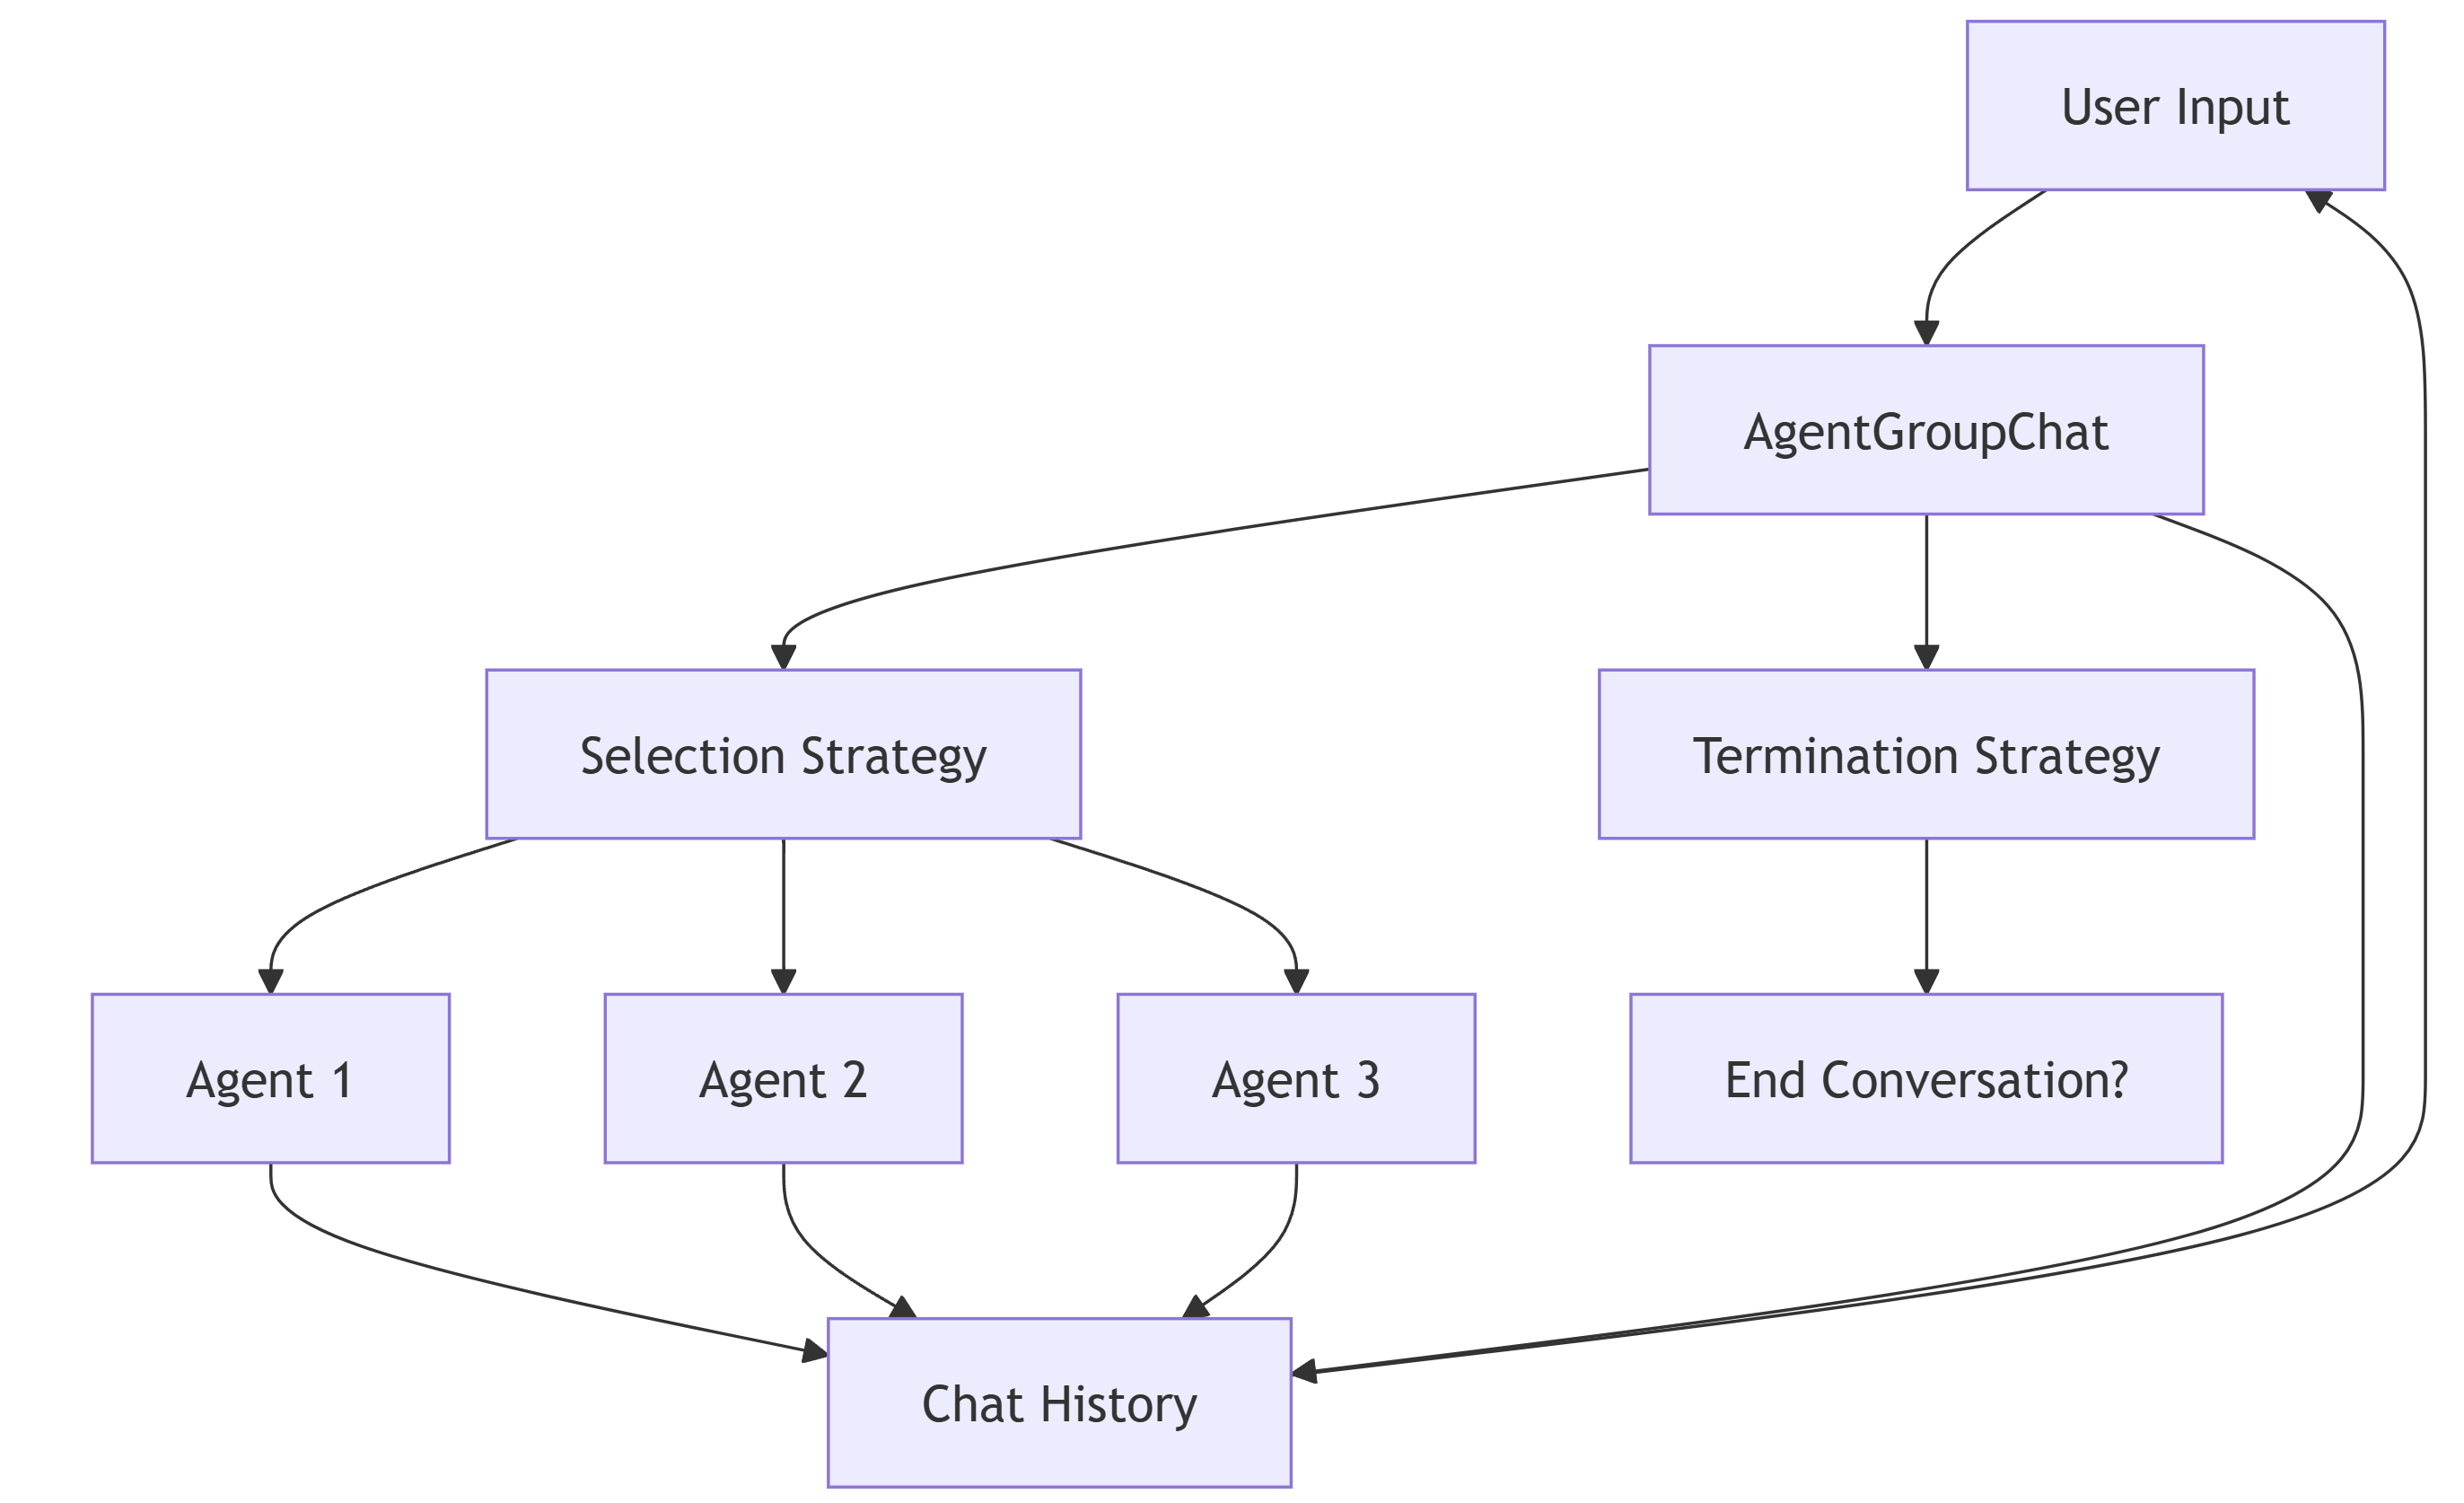

The conversation flow is typically:

1. User adds a message to the group chat
2. Selection strategy chooses which agent responds next
3. Selected agent processes the conversation history and generates a response
4. Response is added to the chat history
5. Termination strategy checks if conversation should end
6. If not terminated, process repeats from step 2

Let's start with a simple example: creating two basic agents and connecting them through an AgentGroupChat.

In [6]:
# Create two simple agents with different perspectives
agent_factual = ChatCompletionAgent(
    kernel=kernel,
    name="Factual",
    instructions="You are a fact-based agent who provides accurate and concise information. Always stick to verified facts and cite sources when possible. Keep your responses very concise, clear and straightforward.",
)

agent_creative = ChatCompletionAgent(
    kernel=kernel,
    name="Creative",
    instructions="You are a creative agent who thinks outside the box. Offer innovative perspectives and unique ideas. Feel free to brainstorm and suggest creative solutions. Keep your responses very concise, imaginative and engaging.",
)

# Create a simple group chat with these agents
simple_group_chat = AgentGroupChat(
    agents=[agent_factual, agent_creative],
    # Use sequential selection (round-robin) and limit to 4 total responses
    selection_strategy=SequentialSelectionStrategy(),
    termination_strategy=DefaultTerminationStrategy(maximum_iterations=4),
)

print(f"Created a simple group chat with {len(simple_group_chat.agents)} agents")
print(
    f"Maximum iterations: {simple_group_chat.termination_strategy.maximum_iterations}"
)

Created a simple group chat with 2 agents
Maximum iterations: 4


Now, let's create a function to run a multi-agent conversation and display the results:

In [7]:
async def run_group_chat(chat, user_message):
    """Run a multi-agent conversation and display the results.

    Args:
        chat: The AgentGroupChat instance
        user_message: The initial user message to start the conversation

    Returns:
        The chat history containing all messages
    """
    # Create a new chat history if needed
    if not hasattr(chat, "history") or chat.history is None:
        # Some versions of AgentGroupChat might not initialize history
        chat_history = ChatHistory()
        chat.history = chat_history

    # Add the user message to the chat
    await chat.add_chat_message(message=user_message)
    print(f"\nUser: {user_message}\n")
    print("=== Beginning Agent Collaboration ===")

    # Track which agent is speaking for formatting
    current_agent = None

    # Invoke the chat and process agent responses
    try:
        async for response in chat.invoke():
            if response is not None and response.name:
                # Add a separator between different agents
                if current_agent != response.name:
                    current_agent = response.name
                    print(f"\n## {response.name}:\n{response.content}")
                else:
                    # Same agent continuing
                    print(f"{response.content}")

        print("\n=== Agent Collaboration Complete ===")
    except Exception as e:
        print(f"Error during chat invocation: {str(e)}")

    # Reset is_complete to allow for further conversations
    chat.is_complete = False

    return chat.history

Let's test our simple group chat with a question that can benefit from both factual and creative perspectives:

In [9]:
# Test the simple group chat with a question
question = "What are some approaches to address climate change?"
chat_history = await run_group_chat(simple_group_chat, question)


User: What are some approaches to address climate change?

=== Beginning Agent Collaboration ===

## Factual:
Approaches to address climate change include:

1. **Renewable Energy**: Transition to solar, wind, and other clean energy sources.
2. **Energy Efficiency**: Improve efficiency in buildings, transportation, and appliances.
3. **Reforestation**: Plant trees to absorb CO2 and restore ecosystems.
4. **Carbon Pricing**: Implement carbon taxes or cap-and-trade systems to limit emissions.
5. **Sustainable Agriculture**: Adopt practices reducing methane and improving soil health.
6. **Electrified Transportation**: Accelerate adoption of electric vehicles and public transit.
7. **Carbon Capture**: Develop technologies to remove CO2 from the atmosphere.
8. **Waste Reduction**: Minimize waste and promote recycling.
9. **International Cooperation**: Enforce treaties like the Paris Agreement.
10. **Education and Advocacy**: Raise awareness and encourage sustainable practices.

Sources: IPC

### Multiple Agent Types and Roles

In a multi-agent system, each agent should have a clearly defined role and purpose. Here are some common agent roles you might implement:

| Role Type | Purpose | Example Instructions |
|-----------|---------|---------------------|
| **Researcher** | Provides factual information | Focus on accurate information with sources |
| **Creative** | Generates novel ideas | Think outside conventional boundaries |
| **Critic** | Analyzes and critiques | Identify weaknesses and suggest improvements |
| **Summarizer** | Condenses information | Extract key points concisely |
| **Moderator** | Guides conversation | Keep discussion on track and productive |
| **Domain Expert** | Provides specialized knowledge | Share deep expertise in a specific field |

Let's create a more sophisticated team of agents with specialized roles:

In [10]:
# Create a team of specialized agents

# 1. Researcher who provides factual information
researcher = ChatCompletionAgent(
    kernel=kernel,
    name="Researcher",
    instructions="""You are a thorough researcher who provides factual information and analysis.
    
    Your responsibilities:
    - Provide accurate, factual information on the topic
    - Analyze questions from multiple angles
    - Consider historical context and current understanding
    - Be objective and balanced in your assessment
    - Acknowledge limitations in current knowledge when appropriate
    
    Always strive for accuracy over speculation. Keep your responses very concise, clear and straightforward.""",
)

# 2. Creative thinker who generates innovative ideas
innovator = ChatCompletionAgent(
    kernel=kernel,
    name="Innovator",
    instructions="""You are an innovative thinker who generates novel ideas and perspectives.
    
    Your responsibilities:
    - Suggest unique approaches and solutions
    - Think beyond conventional boundaries
    - Make unexpected connections between concepts
    - Offer imaginative scenarios and possibilities
    - Propose 'what if' scenarios to expand thinking
    
    Don't be constrained by traditional thinking - be bold and creative. Keep your responses very concise, imaginative and engaging.""",
)

# 3. Critic who evaluates ideas critically
critic = ChatCompletionAgent(
    kernel=kernel,
    name="Critic",
    instructions="""You are a thoughtful critic who evaluates ideas and identifies potential issues.
    
    Your responsibilities:
    - Analyze the strengths and weaknesses of proposals
    - Identify potential problems or limitations
    - Challenge assumptions constructively
    - Suggest improvements to ideas
    - Consider practical implementation challenges
    
    Be constructive in your criticism - your goal is to improve ideas, not dismiss them. Keep your responses very concise, clear and straightforward.""",
)

# 4. Synthesizer who brings ideas together
synthesizer = ChatCompletionAgent(
    kernel=kernel,
    name="Synthesizer",
    instructions="""You are a skilled synthesizer who integrates diverse perspectives into coherent conclusions.
    
    Your responsibilities:
    - Identify common themes across different viewpoints
    - Reconcile apparently conflicting ideas when possible
    - Create a balanced, integrated perspective
    - Summarize key points from the discussion
    - Draw reasonable conclusions from the collective input
    
    Your goal is to bring together different perspectives into a coherent whole. Keep your responses very concise, clear and straightforward.""",
)

# Create a group chat with all specialized agents
expert_team = AgentGroupChat(
    agents=[researcher, innovator, critic, synthesizer],
    selection_strategy=SequentialSelectionStrategy(),
    termination_strategy=DefaultTerminationStrategy(
        maximum_iterations=8
    ),  # 2 rounds of all 4 agents
)

print(f"Created an expert team with {len(expert_team.agents)} specialized agents")

Created an expert team with 4 specialized agents


Now let's test our expert team with the same climate change question to see how their specialized roles affect the collaboration:

In [11]:
# Test the expert team with the same question
chat_history = await run_group_chat(expert_team, question)


User: What are some approaches to address climate change?

=== Beginning Agent Collaboration ===

## Researcher:
Addressing climate change requires a multifaceted approach at the global, national, and local levels. Key approaches include:

1. **Mitigation**: 
   - **Renewable Energy**: Transition to solar, wind, hydro, and geothermal energy to reduce greenhouse gas emissions.
   - **Energy Efficiency**: Improve efficiency in buildings, transportation, and industry to minimize energy use.
   - **Carbon Pricing**: Implement carbon taxes or cap-and-trade systems to incentivize emission reductions.
   - **Afforestation and Reforestation**: Plant trees to absorb carbon dioxide from the atmosphere.

2. **Adaptation**:
   - **Infrastructure**: Build resilient infrastructure to withstand extreme weather events.
   - **Water Management**: Develop systems to manage resources amid changing precipitation patterns.
   - **Agriculture**: Adjust farming practices, such as crop diversification, to co

Compare the two approaches:

1. **Simple Group Chat (2 agents)**:
   - Basic factual and creative perspectives
   - Limited interaction depth
   - Simple back-and-forth exchange

2. **Expert Team (4 specialized agents)**:
   - Multiple specialized perspectives
   - More comprehensive analysis
   - Natural progression from facts → ideas → critique → synthesis

This demonstrates how designing agents with complementary roles can create more valuable interactions and outputs.

### Exercise: Create Your First Multi-Agent Conversation

Now it's your turn to design a multi-agent system! Create a team of 3-4 agents with different, complementary roles to collaborate on a specific type of problem.

Your task:
1. Create 3-4 agents with distinct roles and specialties
2. Create an AgentGroupChat with these agents
3. Test the multi-agent system with a relevant question or task
4. Observe how the agents work together and complement each other

In [ ]:
# Your code here

# 1. Create 3-4 specialized agents
# (Define each agent with a clear role and detailed instructions)


# 2. Create an AgentGroupChat with your agents
# (Set up an appropriate selection and termination strategy)


# 3. Define a relevant question or task for your team


# 4. Run the group chat and observe the interaction

<details>
<summary>Click to see solution</summary>

```python
# 1. Create specialized agents for product development

# Product Manager focuses on user needs and market fit
product_manager = ChatCompletionAgent(
    kernel=kernel,
    name="ProductManager",
    instructions="""You are a strategic product manager focused on user needs and market fit.
    
    Your responsibilities:
    - Identify user problems and needs
    - Evaluate market opportunities and competition
    - Define product requirements and priorities
    - Consider business viability and market fit
    - Focus on user experience and value proposition
    
    Always center your thinking on user problems and how to solve them effectively."""
)

# Engineer focuses on technical implementation
engineer = ChatCompletionAgent(
    kernel=kernel,
    name="Engineer",
    instructions="""You are a technical engineer who focuses on implementation feasibility and technical solutions.
    
    Your responsibilities:
    - Evaluate technical feasibility of proposed features
    - Suggest appropriate technologies and architectures
    - Identify potential technical challenges and limitations
    - Consider scalability, performance, and security implications
    - Propose practical implementation approaches
    
    Think in terms of practical implementation and technical constraints."""
)

# Designer focuses on user experience
designer = ChatCompletionAgent(
    kernel=kernel,
    name="Designer",
    instructions="""You are a user-centered designer who ensures products are usable and delightful.
    
    Your responsibilities:
    - Consider user interactions and experience flows
    - Evaluate accessibility and usability concerns
    - Suggest intuitive interfaces and interactions
    - Think about visual design principles and consistency
    - Address potential user pain points and confusion
    
    Always advocate for the end user's experience and needs."""
)

# Marketing specialist focuses on positioning and communication
marketer = ChatCompletionAgent(
    kernel=kernel,
    name="Marketer",
    instructions="""You are a marketing specialist who thinks about how to position and promote products.
    
    Your responsibilities:
    - Consider how to position the product in the market
    - Identify target audiences and messaging strategies
    - Suggest go-to-market approaches and channels
    - Think about brand alignment and messaging
    - Address potential objections or barriers to adoption
    
    Focus on how to communicate value and drive adoption of the product."""
)

# 2. Create a product development team chat
product_team = AgentGroupChat(
    agents=[product_manager, engineer, designer, marketer],
    selection_strategy=SequentialSelectionStrategy(),
    termination_strategy=DefaultTerminationStrategy(maximum_iterations=8)  # 2 rounds of all 4 agents
)

# 3. Define a product development challenge
product_challenge = "We need to develop a mobile app that helps people track and reduce their carbon footprint in daily life. What approach should we take?"

# 4. Run the product team discussion
await run_group_chat(product_team, product_challenge)

# Analyze how the agents complemented each other
print("\nMulti-Agent Collaboration Analysis:")
print("- The Product Manager focused on user needs and market positioning")
print("- The Engineer addressed technical feasibility and implementation approaches")
print("- The Designer considered user experience and interface design")
print("- The Marketer thought about target audience and adoption strategy")
print("- Together, they provided a comprehensive product development approach")
```
</details>

## 2. Introduction Agent Strategies

In the previous section, we created basic multi-agent systems using `AgentGroupChat` with default strategies. Now let's explore how to build more sophisticated agent collaborations by configuring agents with specialized roles and customizing their interactions.

### Initializing Multiple Specialized Agents

When building effective multi-agent systems, the way you design and initialize your agents is critical. Each agent should have:

1. **Clear purpose**: A well-defined role and responsibility
2. **Specialized instructions**: Guidance on how to approach problems from its unique perspective
3. **Complementary skills**: Abilities that work well with other agents' capabilities
4. **Communication style**: How it should present information to other agents

Let's create a team of specialized agents for a specific task: collaborative writing and editing.

In [12]:
# Create a writer agent that generates content
writer = ChatCompletionAgent(
    kernel=kernel,
    name="Writer",
    instructions="""You are a creative writer who crafts engaging content.
    
    Your role in this collaboration:
    1. Generate original content based on the topic provided
    2. Apply creative storytelling techniques to engage readers
    3. Incorporate feedback from the editor and fact-checker to improve your writing
    4. Revise content to address issues raised by other team members
    5. Focus on creating a compelling narrative voice and structure
    
    When responding to feedback:
    - Be open to constructive criticism
    - Explain your creative choices when relevant
    - Incorporate suggestions that improve the content
    
    Always strive to maintain the core message while making the content more engaging and effective. Keep your responses very concise, imaginative and engaging.""",
)

# Create an editor agent that improves the writing
editor = ChatCompletionAgent(
    kernel=kernel,
    name="Editor",
    instructions="""You are a meticulous editor who improves content quality and clarity.
    
    Your role in this collaboration:
    1. Review content for clarity, coherence, and flow
    2. Identify and fix grammatical, structural, or stylistic issues
    3. Suggest improvements to enhance readability and impact
    4. Ensure the content meets its intended purpose and audience needs
    5. Maintain consistent voice and tone throughout
    
    When providing feedback:
    - Be specific about what needs improvement and why
    - Offer constructive suggestions rather than just criticism
    - Consider both micro (sentence-level) and macro (structure) improvements
    - Balance preserving the writer's voice with improving the content
    
    Your goal is to elevate the writing while respecting the writer's intent and style. Keep your responses very concise, clear and straightforward.""",
)

# Create a fact-checker agent that ensures accuracy
fact_checker = ChatCompletionAgent(
    kernel=kernel,
    name="FactChecker",
    instructions="""You are a thorough fact-checker who ensures accuracy and credibility.
    
    Your role in this collaboration:
    1. Verify factual claims in the content
    2. Identify potential inaccuracies or misleading statements
    3. Suggest corrections for any factual errors
    4. Recommend additional context where needed for accuracy
    5. Ensure the content is truthful and well-supported
    
    When providing feedback:
    - Focus on accuracy rather than style or structure
    - Explain why a statement might be problematic
    - Provide correct information to replace inaccuracies
    - Consider potential sources of factual support
    
    Your goal is to ensure the content maintains high standards of accuracy and integrity. Keep your responses very concise, clear and straightforward.""",
)

print("Created specialized writing team agents successfully!")

Created specialized writing team agents successfully!


### Setting Up a Basic Group Chat

Now that we have our specialized agents, let's set up an `AgentGroupChat` to orchestrate their collaboration. We need to consider:

1. **Agent order**: The sequence in which agents participate
2. **Maximum iterations**: How many turns the conversation should take
3. **Turn-taking logic**: How to determine which agent speaks next

For this example, we'll use a simple sequential approach where agents take turns in a fixed order.

In [13]:
# Create a writing team chat with sequential selection strategy
writing_team = AgentGroupChat(
    agents=[writer, editor, fact_checker],
    # Specify that the writer should start
    selection_strategy=SequentialSelectionStrategy(initial_agent=writer),
    # Limit to 9 turns total (3 rounds × 3 agents)
    termination_strategy=DefaultTerminationStrategy(maximum_iterations=9),
)

print("Writing team chat created with sequential selection strategy")
print(f"Initial agent: {writing_team.selection_strategy.initial_agent.name}")
print(f"Maximum iterations: {writing_team.termination_strategy.maximum_iterations}")

Writing team chat created with sequential selection strategy
Initial agent: Writer
Maximum iterations: 9


The `SequentialSelectionStrategy` we're using has these properties:

- It follows a round-robin pattern, moving through agents in the order they were added
- You can specify an `initial_agent` to start the conversation
- It's predictable and ensures each agent gets a turn to contribute

Now let's test our writing team collaboration with a writing task:

In [ ]:
# Test the writing team with a specific writing task
writing_task = "Write a short blog post about the impact of artificial intelligence on healthcare, focusing on recent advancements and ethical considerations."

# Run the group chat
chat_history = await run_group_chat(writing_team, writing_task)

Did you notice the pattern in the conversation?

1. The **Writer** created the initial draft
2. The **Editor** reviewed it for clarity and style
3. The **FactChecker** verified the factual claims
4. The **Writer** revised based on feedback
5. The **Editor** reviewed the revised version
6. And so on...

This sequential approach mimics a real editorial process where content moves through different stages of review and revision.

### Simple Agent Collaboration Patterns

The sequential selection we just used is one of several agent collaboration patterns. Here are some common patterns you might use:

1. **Sequential (Round-Robin)**: Agents take turns in a fixed order
   - Pros: Simple, predictable, ensures each agent participates
   - Cons: Not responsive to content; might include irrelevant contributions

2. **Fixed Workflow**: Agents follow a specific sequence designed for a task
   - Pros: Mirrors real workflows (e.g., write → edit → approve)
   - Cons: Less flexible for unexpected situations

3. **Dynamic Selection**: An LLM decides which agent should respond next
   - Pros: More responsive to conversation needs; adaptable
   - Cons: Less predictable; requires careful prompt engineering

Let's implement a fixed workflow pattern for our writing team, where we explicitly define the sequence of agents based on the writing process:

In [42]:
from typing import List


# Custom function to create a fixed workflow chat
def create_fixed_workflow_chat(agents, workflow_sequence, max_iterations=None):
    """Create a chat with a fixed agent workflow sequence.

    Args:
        agents: List of agent instances
        workflow_sequence: List of agent names in the desired workflow order
        max_iterations: Maximum number of iterations (default: len(workflow_sequence))
    """
    # Create a mapping of agent names to instances
    agent_map = {agent.name: agent for agent in agents}

    # Verify all workflow agents exist
    for name in workflow_sequence:
        if name not in agent_map:
            raise ValueError(f"Agent '{name}' in workflow not found in provided agents")

    # Create a custom selection strategy class
    class FixedWorkflowStrategy(SelectionStrategy):
        counter: int = 0
        workflow_sequence: List[str]

        async def next(self, agents, messages):
            print("workflow_sequence", self.workflow_sequence)
            agent = agent_map[
                self.workflow_sequence[self.counter % len(self.workflow_sequence)]
            ]
            self.counter += 1
            print("selected:", agent.name)

            self.has_selected = True
            return agent

    # Set maximum iterations if not specified
    if max_iterations is None:
        max_iterations = len(workflow_sequence)

    fixed_workflow_strategy = FixedWorkflowStrategy(workflow_sequence=workflow_sequence)

    # Create and return the AgentGroupChat
    return AgentGroupChat(
        agents=agents,
        selection_strategy=fixed_workflow_strategy,
        termination_strategy=DefaultTerminationStrategy(
            maximum_iterations=max_iterations
        ),
    )


# Define a specific writing workflow
# Writer -> Editor -> FactChecker -> Writer (for revisions) -> Editor (final review)
writing_workflow = ["Writer", "Editor", "FactChecker", "Writer", "Editor"]

# Create the workflow chat
workflow_chat = create_fixed_workflow_chat(
    agents=[writer, editor, fact_checker],
    workflow_sequence=writing_workflow,
    max_iterations=len(writing_workflow),
)

print(f"Created fixed workflow chat with sequence: {' → '.join(writing_workflow)}")

Created fixed workflow chat with sequence: Writer → Editor → FactChecker → Writer → Editor


Now let's test our fixed workflow collaboration with the same writing task:

In [43]:
# Test the workflow chat with the same writing task
chat_history = await run_group_chat(workflow_chat, writing_task)


User: Write a short blog post about the impact of artificial intelligence on healthcare, focusing on recent advancements and ethical considerations.

=== Beginning Agent Collaboration ===
workflow_sequence ['Writer', 'Editor', 'FactChecker', 'Writer', 'Editor']
selected: Writer

## Writer:
**AI in Healthcare: Revolution or Reckoning?**

Artificial intelligence is rewriting the script of modern medicine. From diagnosing diseases in seconds to personalizing treatments with pinpoint precision, AI's advancements are nothing short of extraordinary. Tools like deep-learning algorithms now detect cancer more accurately than some experts, while wearable tech predicts heart attacks before they happen. The efficiency is undeniable—but so is the ethical tension.

With great data comes great responsibility. Who owns your health data when AI analyzes it? What happens if algorithms make mistakes, or worse, perpetuate bias? Balancing innovation with accountability has never been more crucial. Transp

The fixed workflow gives us more control over the exact sequence of agent interactions. This is especially useful for process-oriented tasks that have a natural sequence, like content creation and review.

Notice how we customized the workflow to match a realistic content creation process:
1. **Writer**: Creates initial draft
2. **Editor**: Reviews for style and clarity
3. **FactChecker**: Verifies accuracy
4. **Writer**: Revises based on all feedback
5. **Editor**: Gives final approval

This is more directed than the simple round-robin approach and can lead to a more efficient collaboration for specific tasks.

### Exercise: Implement a Two-Agent Interaction System

Now it's your turn to implement a specialized two-agent interaction system. Create two agents with complementary roles that can collaborate effectively on a specific task.

Your task:
1. Create two specialized agents with clear, complementary roles
2. Set up an AgentGroupChat with an appropriate selection strategy
3. Define a specific problem or task for them to collaborate on
4. Test and demonstrate their interaction

In [ ]:
# Your code here

# 1. Create two specialized agents with complementary roles
# (Make sure their instructions are detailed and clearly define their responsibilities)


# 2. Set up an AgentGroupChat with appropriate strategies
# (Consider whether a sequential or custom strategy would work best)


# 3. Define a specific problem or task
# (Choose something that benefits from both agents' perspectives)


# 4. Test the interaction
# (Run the chat and observe how they collaborate)

<details>
<summary>Click to see solution</summary>

```python
# 1. Create two specialized agents for debating a topic

# Proponent argues in favor of a position
proponent = ChatCompletionAgent(
    kernel=kernel,
    name="Proponent",
    instructions="""You are a persuasive advocate who makes strong arguments in favor of a position.
    
    Your role in this debate:
    - Present compelling arguments supporting the given position
    - Use evidence, logic, and persuasive techniques to strengthen your case
    - Address counterarguments raised by the opponent
    - Focus on the strongest points in favor of your position
    - Maintain a respectful, fact-based approach
    
    When responding to the opponent:
    - Acknowledge their points before presenting counterarguments
    - Find weaknesses in their reasoning or evidence
    - Redirect the conversation to your stronger arguments
    
    Your goal is to make the most compelling case possible for your position."""
)

# Opponent argues against the position
opponent = ChatCompletionAgent(
    kernel=kernel,
    name="Opponent",
    instructions="""You are a critical thinker who makes strong arguments against a position.
    
    Your role in this debate:
    - Present compelling arguments challenging the given position
    - Identify weaknesses, limitations, or unintended consequences
    - Use evidence, logic, and critical analysis to strengthen your case
    - Address arguments raised by the proponent
    - Maintain a respectful, fact-based approach
    
    When responding to the proponent:
    - Acknowledge their strongest points
    - Identify logical fallacies or evidentiary gaps
    - Present alternative perspectives or solutions
    
    Your goal is to provide a balanced counterargument and critical evaluation."""
)

# 2. Set up a debate format with alternating speakers
debate_chat = AgentGroupChat(
    agents=[proponent, opponent],
    selection_strategy=SequentialSelectionStrategy(initial_agent=proponent),
    termination_strategy=DefaultTerminationStrategy(maximum_iterations=6)  # 3 exchanges each
)

# 3. Define a controversial topic for debate
debate_topic = "Topic for debate: Should social media platforms be responsible for moderating user content?"

# 4. Run the debate
print("=== Starting Structured Debate ===\n")
print("Format: Proponent and Opponent will alternately present their cases\n")

debate_history = await run_group_chat(debate_chat, debate_topic)

# Analyze results
print("\n=== Debate Analysis ===")
print("The debate demonstrated how two specialized agents can engage in structured argumentation:")
print("- The Proponent consistently made the case FOR platform responsibility")
print("- The Opponent systematically challenged these arguments")
print("- Each agent built on previous points while addressing counterarguments")
print("- The alternating structure ensured balanced representation of both positions")
```
</details>

### Key Takeaways

In these sections, we've learned how to:

1. **Transition from single agents to multi-agent systems**
   - Understand when and why multiple agents are beneficial
   - Design agents with complementary roles and specializations

2. **Work with AgentGroupChat**
   - Create and configure a basic group chat
   - Understand key components like selection and termination strategies
   - Run multi-agent conversations and process responses

3. **Implement different agent collaboration patterns**
   - Use sequential (round-robin) selection
   - Create fixed workflow sequences
   - Design specialized agent teams for specific tasks

In the next section, we'll explore more advanced techniques for controlling multi-agent conversations, including custom selection and termination strategies.